Screen resolution: 3456 x 2234 pixels
Image dimensions: 3456 x 2234 pixels


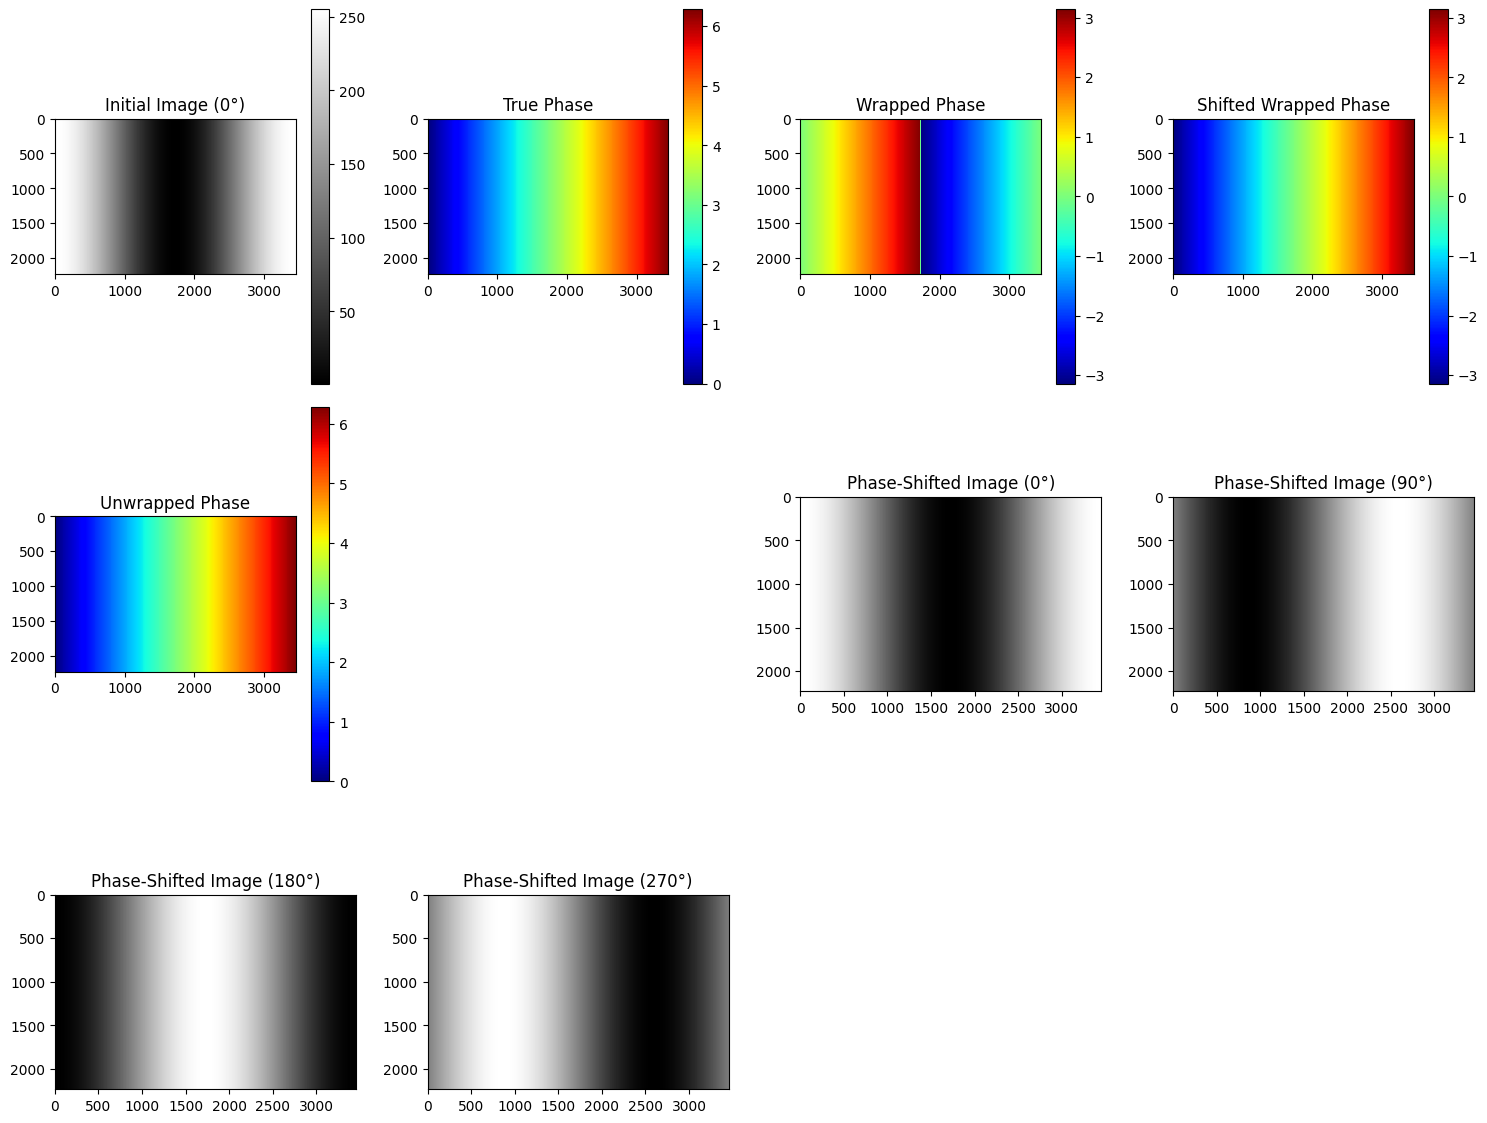

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase

# Function to generate a sinusoidal fringe pattern with one period
def generate_sinusoidal_fringe_pattern(shape, amplitude=1.0, background=1.0, orientation='vertical'):
    """
    Generate an initial image with a sinusoidal fringe pattern of one period.
    
    Parameters:
    - shape: Tuple (height, width) of the image.
    - amplitude: Amplitude of the sinusoidal pattern.
    - background: Background intensity (DC component).
    - orientation: 'vertical' for vertical fringes, 'horizontal' for horizontal fringes.
    
    Returns:
    - initial_image: Initial image with sinusoidal fringe pattern.
    - true_phase: True phase map of the fringe pattern.
    """
    height, width = shape
    if orientation == 'vertical':
        x = np.linspace(0, 2 * np.pi, width)  # One period across the width
        X = np.tile(x, (height, 1))  # Repeat the pattern vertically
        true_phase = X  # Phase varies from 0 to 2pi across the width
    elif orientation == 'horizontal':
        y = np.linspace(0, 2 * np.pi, height)  # One period across the height
        Y = np.tile(y, (width, 1)).T  # Repeat the pattern horizontally
        true_phase = Y  # Phase varies from 0 to 2pi across the height
    else:
        raise ValueError("Orientation must be 'vertical' or 'horizontal'")
    
    initial_image = background + amplitude * np.cos(true_phase)
    return initial_image, true_phase

# Function to generate four phase-shifted images
def generate_phase_shifted_images(initial_image, true_phase):
    """
    Generate four phase-shifted images from the initial image.
    
    Parameters:
    - initial_image: Initial image with sinusoidal fringe pattern.
    - true_phase: True phase map of the initial image.
    
    Returns:
    - I1, I2, I3, I4: Four phase-shifted images (0, pi/2, pi, 3pi/2).
    """
    background = np.mean(initial_image)  # Estimate background intensity
    amplitude = (np.max(initial_image) - np.min(initial_image)) / 2  # Estimate amplitude
    
    I1 = background + amplitude * np.cos(true_phase)  # 0 phase shift
    I2 = background + amplitude * np.cos(true_phase + np.pi/2)  # pi/2 phase shift
    I3 = background + amplitude * np.cos(true_phase + np.pi)  # pi phase shift
    I4 = background + amplitude * np.cos(true_phase + 3*np.pi/2)  # 3pi/2 phase shift
    
    return I1, I2, I3, I4

# Function to implement the 4-phase shift algorithm
def four_phase_shift_algorithm(I1, I2, I3, I4):
    """
    Apply the 4-phase shift algorithm to extract the phase map.
    
    Parameters:
    - I1, I2, I3, I4: Four phase-shifted images.
    
    Returns:
    - wrapped_phase: Wrapped phase map in the range [-pi, pi].
    - amplitude: Amplitude map of the interference pattern.
    - background: Background intensity map.
    """
    numerator = I4 - I2
    denominator = I1 - I3
    wrapped_phase = np.arctan2(numerator, denominator)
    amplitude = np.sqrt((I1 - I3)**2 + (I4 - I2)**2)
    background = (I1 + I2 + I3 + I4) / 4.0
    return wrapped_phase, amplitude, background

# Function to shift the phase jump
def shift_phase_jump(phi_old, delta_phi_off):
    """
    Shift the phase jump in the wrapped phase map by adding a constant phase offset.
    
    Parameters:
    - phi_old: Original wrapped phase map.
    - delta_phi_off: Constant phase offset to add (in radians).
    
    Returns:
    - phi_new: New wrapped phase map with the phase jump shifted.
    """
    phi_new = np.angle(np.exp(1j * (phi_old + delta_phi_off)))
    return phi_new

# Function to visualize results
def plot_results(initial_image, true_phase, I1, I2, I3, I4, wrapped_phase, shifted_phase, unwrapped_phase):
    """
    Visualize the initial image, phase-shifted images, true phase, wrapped phase, shifted phase, and unwrapped phase.
    """
    plt.figure(figsize=(15, 12))
    
    plt.subplot(3, 4, 1)
    plt.imshow(initial_image, cmap='gray')
    plt.title('Initial Image (0°)')
    plt.colorbar()
    
    plt.subplot(3, 4, 2)
    plt.imshow(true_phase, cmap='jet')
    plt.title('True Phase')
    plt.colorbar()
    
    plt.subplot(3, 4, 3)
    plt.imshow(wrapped_phase, cmap='jet')
    plt.title('Wrapped Phase')
    plt.colorbar()
    
    plt.subplot(3, 4, 4)
    plt.imshow(shifted_phase, cmap='jet')
    plt.title('Shifted Wrapped Phase')
    plt.colorbar()
    
    plt.subplot(3, 4, 5)
    plt.imshow(unwrapped_phase, cmap='jet')
    plt.title('Unwrapped Phase')
    plt.colorbar()
    
    plt.subplot(3, 4, 7)
    plt.imshow(I1, cmap='gray')
    plt.title('Phase-Shifted Image (0°)')
    
    plt.subplot(3, 4, 8)
    plt.imshow(I2, cmap='gray')
    plt.title('Phase-Shifted Image (90°)')
    
    plt.subplot(3, 4, 9)
    plt.imshow(I3, cmap='gray')
    plt.title('Phase-Shifted Image (180°)')
    
    plt.subplot(3, 4, 10)
    plt.imshow(I4, cmap='gray')
    plt.title('Phase-Shifted Image (270°)')
    
    plt.tight_layout()
    plt.show()

# Main script
if __name__ == "__main__":
    # Hardcode your screen size (16-inch, 3456 × 2234)
    screen_width, screen_height = 3456, 2234
    print(f"Screen resolution: {screen_width} x {screen_height} pixels")
    
    # Set image dimensions to match screen size (or a fraction of it)
    scaling_factor = 1.0  # Use 80% of the screen size to avoid overly large images
    width = int(screen_width * scaling_factor)
    height = int(screen_height * scaling_factor)
    print(f"Image dimensions: {width} x {height} pixels")
    
    # Generate the initial image with a sinusoidal fringe pattern (one period)
    initial_image, true_phase = generate_sinusoidal_fringe_pattern(
        (height, width), amplitude=127, background=128, orientation='vertical'
    )
    
    # Generate four phase-shifted images
    I1, I2, I3, I4 = generate_phase_shifted_images(initial_image, true_phase)
    
    # Apply the 4-phase shift algorithm
    wrapped_phase, amplitude, background = four_phase_shift_algorithm(I1, I2, I3, I4)
    
    # Shift the phase jump to the edge of the FOV (e.g., to x=0)
    delta_phi_off = np.pi  # Shift the phase jump to the left edge
    shifted_phase = shift_phase_jump(wrapped_phase, delta_phi_off)
    
    # Unwrap the phase to get the continuous phase map
    unwrapped_phase = unwrap_phase(wrapped_phase)
    
    # Visualize the results
    plot_results(initial_image, true_phase, I1, I2, I3, I4, wrapped_phase, shifted_phase, unwrapped_phase)